In [1]:
!pip install transformers
!pip install datasets
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import random
import time
import datetime
import re
from tqdm.notebook import tqdm
import random

import csv
import os

import torch

# BERT 사용을 위함
# from transformers import BertTokenizerFast
# from transformers import AlbertTokenizer
from transformers import AutoTokenizer
from transformers import ElectraForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from transformers import pipeline
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Dataset
from copy import deepcopy

# 전처리 및 평가 지표
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, hamming_loss
import matplotlib.pyplot as plt

In [4]:
# 중립: 0, 긍정: 1, 부정: 2
train_df = pd.read_csv('/content/drive/MyDrive/AI 코드/감성분류 모델/train_df.csv')
train_df
# train_df = pd.read_csv('train_df.csv')
# train_df

,document,labels
0,둘쨋날은 미친듯이 밟아봤더니 기어가 헛돌면서 틱틱 소리가 나서 경악.,2
1,"이거 뭐 삐꾸를 준 거 아냐 불안하고, 거금 투자한 게 왜 이래.. 싶어서 정이 확...",2
2,간사하게도 그 이후에는 라이딩이 아주 즐거워져서 만족스럽게 탔다.,1
3,벌써 꽃가루 날리고 날벌레 날아다녀서 좀 방해되는 구간이 있긴 했지만 전반적으로 도...,1
4,샥이 없는 모델이라 일반 도로에서 타면 노면의 진동 때문에 손목이 덜덜덜 떨리고 이...,0
...,...,...
11770,"사용으로 카드 인한 혜택이 명확하고, 친절한 고객 서비스 때문에 만족스러웠어요.",1
11771,"카드 사용으로 인한 혜택이 친절한 명확하고, 고객 서비스 때문에 만족스러웠어요.",1
11772,"카드 사용으로 혜택이 인한 명확하고, 친절한 고객 서비스 때문에 만족스러웠어요.",1
11773,받은 광고에 언급된 혜택과 실제로 카드 혜택이 일치해서 만족해요.,1


In [5]:
test_df = pd.read_csv('/content/drive/MyDrive/AI 코드/감성분류 모델/val_df.csv')
test_df
# test_df = pd.read_csv('val_df.csv')
# test_df

,document,labels
0,엄마 사드렸는데 배도 편하게 눌러주고 미디가 길어 편하다고...다섯가지 색상 모두...,1
1,색깔도 다양하고 핏도 이쁘네요. 다만 인견이라곤해도 시원한 인견은 아니고 오늘같은 ...,0
2,사이즈가 크게 나왔으니 꼭~~확인하세요. 제가 엉덩이와 허벅지가 굵어서 사이즈를 크...,1
3,여름에 입긴 시원하거나 얇진 않고 지금 입기 딱 좋은 두께감과 지금 입기 좋은 원단...,1
4,사이즈가 조금 크게 나온거 같아요. 바지는 입으면 편하고 좋아요. 한치수 작게 주문...,0
...,...,...
241,소비자들이 가장 많이 사용하는 상품중 고르고 고른 상품 중 하나입니다. 친구가 이...,1
242,꽃이 피는 계절이 오려고 이렇게 한 번 더 추운 것이라고 여겨야 하겠습니다. 다리...,2
243,온 가족이 사용할 수 있는 제품이라 안심하고 선택한 상품 소개해요. 가격대비 품질...,1
244,붉은 노을 속에서 멋지게 걸어 나오는 영웅의 모습과 하루 일을 끝마치고 돌아가는 믿...,1


In [ ]:
# 특수문자 제거
def preprocess(df):
    for idx, row in tqdm(df.iterrows(), desc='preprocess', total=len(df)):
        new_doc = re.sub('[^가-힣a-zA-Z]', ' ', row['document']).strip()
        df.loc[idx, 'clean_document'] = new_doc
    return df

train_df = preprocess(train_df)
test_df = preprocess(test_df)

preprocess:   0%|          | 0/11775 [00:00<?, ?it/s]

preprocess:   0%|          | 0/246 [00:00<?, ?it/s]

In [ ]:
train_df

,document,labels,clean_document
0,둘쨋날은 미친듯이 밟아봤더니 기어가 헛돌면서 틱틱 소리가 나서 경악.,2,둘쨋날은 미친듯이 밟아봤더니 기어가 헛돌면서 틱틱 소리가 나서 경악
1,네,1,네
2,아니오,2,아니오
3,아니요,2,아니요
4,"이거 뭐 삐꾸를 준 거 아냐 불안하고, 거금 투자한 게 왜 이래.. 싶어서 정이 확...",2,이거 뭐 삐꾸를 준 거 아냐 불안하고 거금 투자한 게 왜 이래 싶어서 정이 확...
...,...,...,...
11770,"사용으로 카드 인한 혜택이 명확하고, 친절한 고객 서비스 때문에 만족스러웠어요.",1,사용으로 카드 인한 혜택이 명확하고 친절한 고객 서비스 때문에 만족스러웠어요
11771,"카드 사용으로 인한 혜택이 친절한 명확하고, 고객 서비스 때문에 만족스러웠어요.",1,카드 사용으로 인한 혜택이 친절한 명확하고 고객 서비스 때문에 만족스러웠어요
11772,"카드 사용으로 혜택이 인한 명확하고, 친절한 고객 서비스 때문에 만족스러웠어요.",1,카드 사용으로 혜택이 인한 명확하고 친절한 고객 서비스 때문에 만족스러웠어요
11773,받은 광고에 언급된 혜택과 실제로 카드 혜택이 일치해서 만족해요.,1,받은 광고에 언급된 혜택과 실제로 카드 혜택이 일치해서 만족해요


In [ ]:
train_df.to_csv('train_data.csv', index=False, encoding='utf-8-sig')
test_df.to_csv('test_data.csv', index=False, encoding='utf-8-sig')

In [ ]:
from datasets import load_dataset

In [ ]:
all_data = load_dataset(
        "csv",
        data_files={
            "train": "train_data.csv",
        },
    )

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/user/.cache/huggingface/datasets/csv/default-c1a802a8311c5588/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# train_cs = all_data["train"]
# train_cs

In [ ]:
cs = all_data['train'].train_test_split(0.2)
train_cs = cs["train"]
valid_cs = cs["test"]

In [ ]:
train_cs

Dataset({
    features: ['document', 'labels', 'clean_document'],
    num_rows: 9420
})

In [ ]:
valid_cs

Dataset({
    features: ['document', 'labels', 'clean_document'],
    num_rows: 2355
})

In [ ]:
test_data = load_dataset(
        "csv",
        data_files={
            "test": "test_data.csv",
        },
    )
test_data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/user/.cache/huggingface/datasets/csv/default-303537b03cfd9a85/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['document', 'labels', 'clean_document'],
        num_rows: 246
    })
})

In [ ]:
test_cs = test_data['test']
test_cs

Dataset({
    features: ['document', 'labels', 'clean_document'],
    num_rows: 246
})

## Dataset, DataLoader 구성

In [ ]:
class TextClassificationDataset(Dataset):

    def __init__(self, df):
        super().__init__()

        self.labels = df['labels']
        self.texts = df['clean_document']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]


class TextClassificationCollator:

    def __init__(self, tokenizer, max_length, with_text=False):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.with_text = with_text

    def __call__(self, samples):
        texts, labels = zip(*samples)

        inputs = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        return_value = {
            "input_ids": inputs["input_ids"],
            "attention_mask": inputs["attention_mask"],
            "labels": torch.tensor(labels, dtype=torch.long),
        }
        if self.with_text:
            return_value["texts"] = texts

        return return_value

In [ ]:
num_labels = 3
# CLS 토큰 위에 분류를 위한 출력층을 붙인 모델 아키텍쳐을 바로 load
# 3개 중에 하나로 분류하는 출력층이 붙인 채로 load가 됨
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator", num_labels=num_labels)
model.cuda()

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
# 옵티마이저 선택
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

In [ ]:
train_cs

Dataset({
    features: ['document', 'labels', 'clean_document'],
    num_rows: 9420
})

In [ ]:
device = torch.device("cuda")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v2-discriminator")

In [ ]:
train_dataset = TextClassificationDataset(train_cs)
collator = TextClassificationCollator(tokenizer, max_length = 128)
train_dataloader = DataLoader(
    train_dataset,
    batch_size = 32,
    collate_fn = collator,
    shuffle=True
)

In [ ]:
valid_dataset = TextClassificationDataset(valid_cs)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size = 32,
    collate_fn = collator,
    shuffle=False
)

In [ ]:
test_dataset = TextClassificationDataset(test_cs)
test_dataloader = DataLoader(
    test_dataset,
    batch_size = 32,
    collate_fn = collator,
    shuffle=False
)

In [ ]:
epochs = 100
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))  # hh:mm:ss

In [ ]:
def metrics(predictions, labels):
    y_pred = predictions
    y_true = labels

    # 사용 가능한 메트릭들을 사용한다.
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=0)
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0)
    f1_weighted_average = f1_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0)

    # 메트릭 결과에 대해서 리턴
    metrics = {'accuracy': accuracy,
               'f1_macro': f1_macro_average,
               'f1_micro': f1_micro_average,
               'f1_weighted': f1_weighted_average}

    return metrics

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060


# 모델 학습

In [ ]:
seed_val = 777
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Initialize variables for early stopping
best_valid_accuracy = 0.0
best_valid_loss = float('inf')
early_stopping_counter = 0
early_stopping_patience = 3  # Number of epochs to wait for improvement
# max_epochs = 100  # Maximum number of training epochs

train_loss_history, valid_loss_history = [], []
valid_acc_history = []
model.zero_grad()
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_loss = 0

    model.train()

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        batch = tuple(t[1].to(device) for t in batch.items())
        b_input_ids, b_input_mask, b_labels = batch

        outputs = model(b_input_ids, # 학습 데이터
                        token_type_ids=None, # 세그먼트 임베딩, 문장이나 문서 1개를 사용할 때는 쓸 필요없음
                        attention_mask=b_input_mask,
                        labels=b_labels)  # Calculate loss during training

        loss = outputs[0] # BertForSequenceClassification이 뱉는 output에서 인덱스 0번의 .item()이 loss. HuggingFace 공식 문서에서 나와 있음
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # gradient clipping if it is over a threshold
        optimizer.step()
        scheduler.step()

        model.zero_grad()

    avg_train_loss = total_loss / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # Validation
    model.eval()
    accum_logits, accum_label_ids = [], []
    validation_loss = 0
    for batch in tqdm(valid_dataloader, total=len(valid_dataloader)):
        batch = tuple(t[1].to(device) for t in batch.items())
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels) # Calculate loss during validation

        logits = outputs.logits  # Access the logits attribute of the outputs
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        for b in logits:
            accum_logits.append(np.argmax(b))

        for b in label_ids:
            accum_label_ids.append(b)

        # Calculate the validation loss for this batch and accumulate it
        batch_loss = outputs.loss.item()
        validation_loss += batch_loss

    accum_logits = np.array(accum_logits)
    accum_label_ids = np.array(accum_label_ids)
    results = metrics(accum_logits, accum_label_ids)

    # Calculate the average validation loss over all batches
    avg_validation_loss = validation_loss / len(valid_dataloader)
    valid_accuracy = results['accuracy']

    train_loss_history += [avg_train_loss]
    valid_loss_history += [avg_validation_loss]
    valid_acc_history += [valid_accuracy]
    print("Validation Accuracy: {0:.4f}".format(valid_accuracy))
    print("Validation F1 (Macro) Score: {0:.4f}".format(results['f1_macro']))
    print("Validation F1 (Micro) Score: {0:.4f}".format(results['f1_micro']))
    print("Validation F1 (Weighted) Score: {0:.4f}".format(results['f1_weighted']))
    print("Average Validation Loss: {0:.4f}".format(avg_validation_loss))

    # Check if validation accuracy has improved
    if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy
        early_stopping_counter = 0

        # Store the state_dict of the current best model
        best_model = deepcopy(model.state_dict())
        print("Updated the best model.")
    else:
        early_stopping_counter += 1

    # Check for early stopping based on accuracy
    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered. No improvement for {} consecutive epochs.".format(early_stopping_patience))

        if best_model is not None:
            # Load the best model
            model.load_state_dict(best_model)

        break  # Stop training
# training loop ends here

======== Epoch 1 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.7563
  Training epcoh took: 0:01:49


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.7223
Validation F1 (Macro) Score: 0.4685
Validation F1 (Micro) Score: 0.7223
Validation F1 (Weighted) Score: 0.6622
Average Validation Loss: 0.6565
Updated the best model.
======== Epoch 2 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.5934
  Training epcoh took: 0:01:49


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.7847
Validation F1 (Macro) Score: 0.6359
Validation F1 (Micro) Score: 0.7847
Validation F1 (Weighted) Score: 0.7709
Average Validation Loss: 0.5218
Updated the best model.
======== Epoch 3 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.4691
  Training epcoh took: 0:01:52


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.8238
Validation F1 (Macro) Score: 0.7225
Validation F1 (Micro) Score: 0.8238
Validation F1 (Weighted) Score: 0.8213
Average Validation Loss: 0.4404
Updated the best model.
======== Epoch 4 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.3537
  Training epcoh took: 0:01:50


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.8960
Validation F1 (Macro) Score: 0.8488
Validation F1 (Micro) Score: 0.8960
Validation F1 (Weighted) Score: 0.8929
Average Validation Loss: 0.3608
Updated the best model.
======== Epoch 5 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.2659
  Training epcoh took: 0:01:51


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.8824
Validation F1 (Macro) Score: 0.8309
Validation F1 (Micro) Score: 0.8824
Validation F1 (Weighted) Score: 0.8804
Average Validation Loss: 0.3705
======== Epoch 6 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.2075
  Training epcoh took: 0:01:49


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.8968
Validation F1 (Macro) Score: 0.8600
Validation F1 (Micro) Score: 0.8968
Validation F1 (Weighted) Score: 0.8975
Average Validation Loss: 0.3752
Updated the best model.
======== Epoch 7 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.1740
  Training epcoh took: 0:01:50


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.8972
Validation F1 (Macro) Score: 0.8627
Validation F1 (Micro) Score: 0.8972
Validation F1 (Weighted) Score: 0.8991
Average Validation Loss: 0.3324
Updated the best model.
======== Epoch 8 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.1519
  Training epcoh took: 0:01:48


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.8832
Validation F1 (Macro) Score: 0.8528
Validation F1 (Micro) Score: 0.8832
Validation F1 (Weighted) Score: 0.8854
Average Validation Loss: 0.4719
======== Epoch 9 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.1209
  Training epcoh took: 0:01:51


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.9125
Validation F1 (Macro) Score: 0.8832
Validation F1 (Micro) Score: 0.9125
Validation F1 (Weighted) Score: 0.9119
Average Validation Loss: 0.4084
Updated the best model.
======== Epoch 10 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.1129
  Training epcoh took: 0:01:49


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.9130
Validation F1 (Macro) Score: 0.8842
Validation F1 (Micro) Score: 0.9130
Validation F1 (Weighted) Score: 0.9127
Average Validation Loss: 0.4217
Updated the best model.
======== Epoch 11 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.0898
  Training epcoh took: 0:01:50


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.9193
Validation F1 (Macro) Score: 0.8893
Validation F1 (Micro) Score: 0.9193
Validation F1 (Weighted) Score: 0.9184
Average Validation Loss: 0.4497
Updated the best model.
======== Epoch 12 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.0960
  Training epcoh took: 0:01:49


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.9011
Validation F1 (Macro) Score: 0.8673
Validation F1 (Micro) Score: 0.9011
Validation F1 (Weighted) Score: 0.9034
Average Validation Loss: 0.4588
======== Epoch 13 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.0646
  Training epcoh took: 0:01:51


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.9236
Validation F1 (Macro) Score: 0.8957
Validation F1 (Micro) Score: 0.9236
Validation F1 (Weighted) Score: 0.9223
Average Validation Loss: 0.4664
Updated the best model.
======== Epoch 14 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.0569
  Training epcoh took: 0:01:49


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.9011
Validation F1 (Macro) Score: 0.8657
Validation F1 (Micro) Score: 0.9011
Validation F1 (Weighted) Score: 0.9012
Average Validation Loss: 0.5116
======== Epoch 15 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.0517
  Training epcoh took: 0:01:47


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.9270
Validation F1 (Macro) Score: 0.8993
Validation F1 (Micro) Score: 0.9270
Validation F1 (Weighted) Score: 0.9257
Average Validation Loss: 0.4259
Updated the best model.
======== Epoch 16 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.0523
  Training epcoh took: 0:01:48


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.9227
Validation F1 (Macro) Score: 0.8967
Validation F1 (Micro) Score: 0.9227
Validation F1 (Weighted) Score: 0.9226
Average Validation Loss: 0.4732
======== Epoch 17 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.0485
  Training epcoh took: 0:01:49


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.9223
Validation F1 (Macro) Score: 0.8942
Validation F1 (Micro) Score: 0.9223
Validation F1 (Weighted) Score: 0.9214
Average Validation Loss: 0.4703
======== Epoch 18 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.0425
  Training epcoh took: 0:01:50


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.9291
Validation F1 (Macro) Score: 0.9017
Validation F1 (Micro) Score: 0.9291
Validation F1 (Weighted) Score: 0.9276
Average Validation Loss: 0.5558
Updated the best model.
======== Epoch 19 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.0398
  Training epcoh took: 0:01:50


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.9163
Validation F1 (Macro) Score: 0.8903
Validation F1 (Micro) Score: 0.9163
Validation F1 (Weighted) Score: 0.9163
Average Validation Loss: 0.5267
======== Epoch 20 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.0360
  Training epcoh took: 0:01:49


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.9180
Validation F1 (Macro) Score: 0.8924
Validation F1 (Micro) Score: 0.9180
Validation F1 (Weighted) Score: 0.9178
Average Validation Loss: 0.5577
======== Epoch 21 / 100 ========


  0%|          | 0/295 [00:00<?, ?it/s]


  Average training loss: 0.0366
  Training epcoh took: 0:01:49


  0%|          | 0/74 [00:00<?, ?it/s]

Validation Accuracy: 0.9231
Validation F1 (Macro) Score: 0.8973
Validation F1 (Micro) Score: 0.9231
Validation F1 (Weighted) Score: 0.9222
Average Validation Loss: 0.5473
Early stopping triggered. No improvement for 3 consecutive epochs.


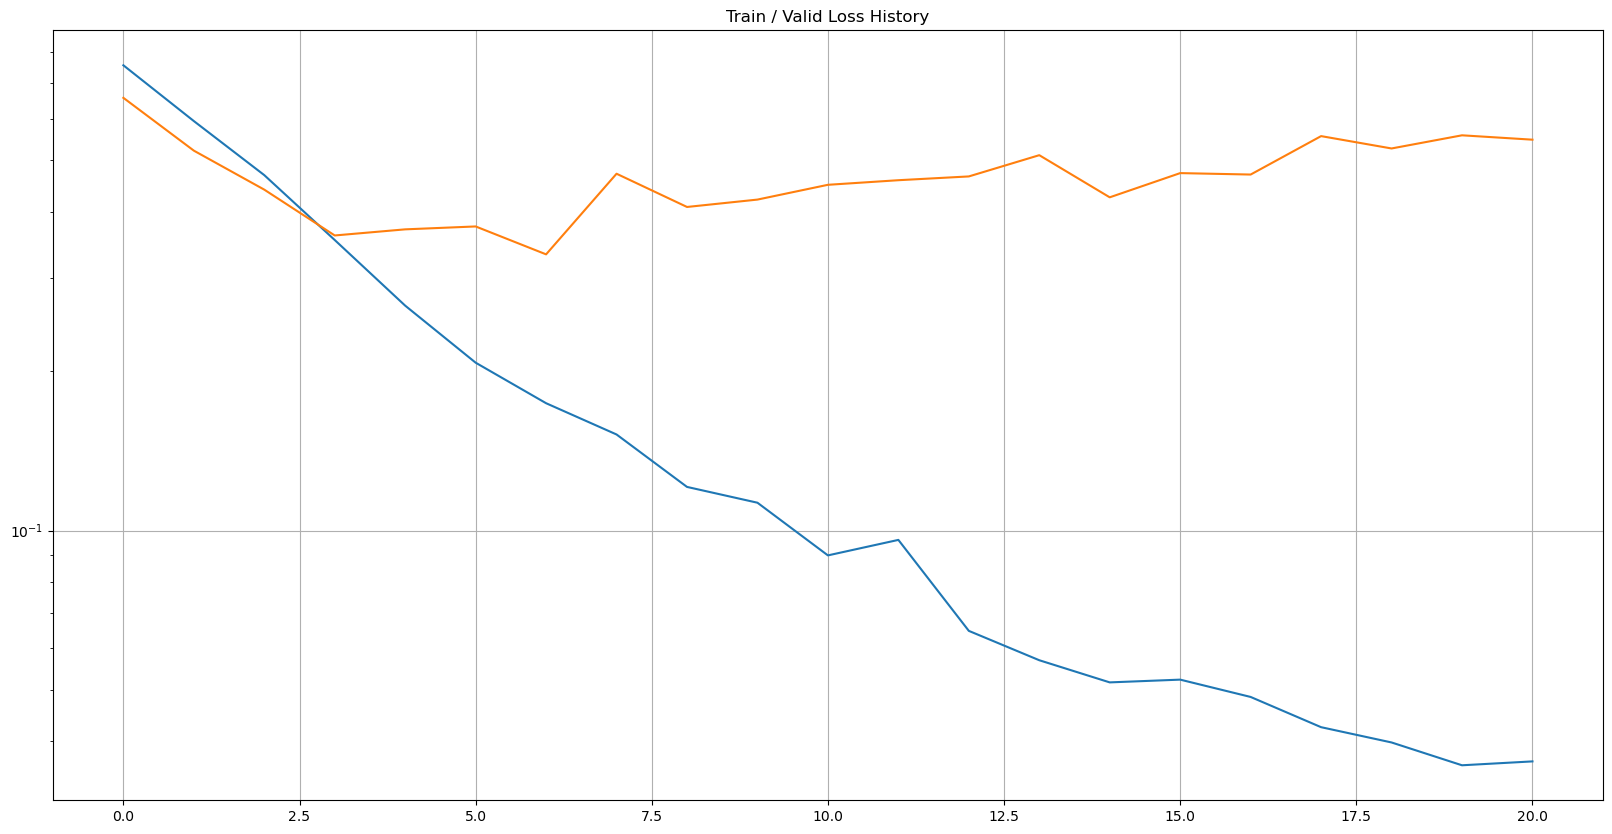

In [ ]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_loss_history)), train_loss_history[plot_from:],
    range(plot_from, len(valid_loss_history)), valid_loss_history[plot_from:],
)
plt.yscale('log')
plt.show()

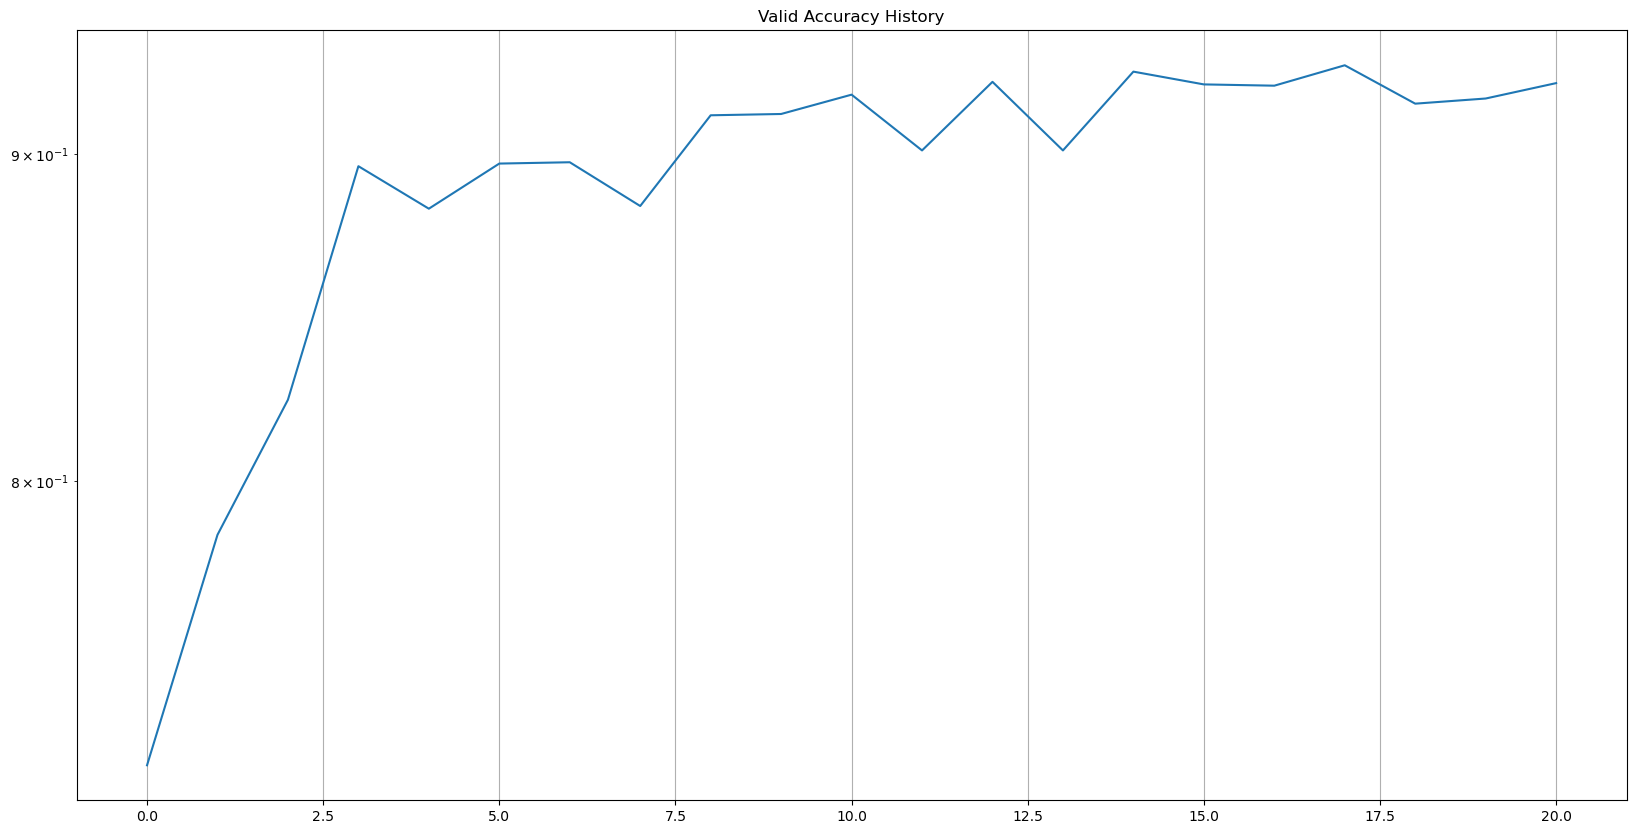

In [ ]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Valid Accuracy History")
plt.plot(
    range(plot_from, len(valid_acc_history)), valid_acc_history[plot_from:],
)
plt.yscale('log')
plt.show()

# 평가

## 테스트 데이터

In [ ]:
t0 = time.time()
model.eval()
accum_logits, accum_label_ids = [], []

for step, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    batch = tuple(t[1].to(device) for t in batch.items())
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    for b in logits:
        # 3개의 값 중 가장 큰 값을 예측한 인덱스로 결정
        # ex) [ 3.5134246  -0.30875662 -2.111316  ] ==> 0
        accum_logits.append(np.argmax(b))

    for b in label_ids:
        accum_label_ids.append(b)

accum_logits = np.array(accum_logits)
accum_label_ids = np.array(accum_label_ids)
results = metrics(accum_logits, accum_label_ids)

print("Accuracy: {0:.4f}".format(results['accuracy']))
print("F1 (Macro) Score: {0:.4f}".format(results['f1_macro']))
print("F1 (Micro) Score: {0:.4f}".format(results['f1_micro']))
print("F1 (Weighted) Score: {0:.4f}".format(results['f1_weighted']))

  0%|          | 0/8 [00:00<?, ?it/s]

Accuracy: 0.7398
F1 (Macro) Score: 0.6224
F1 (Micro) Score: 0.7398
F1 (Weighted) Score: 0.7362


# 모델 저장

In [ ]:
# path = '/content/drive/MyDrive/sentiment_analysis/'

In [ ]:
# 모델 저장
# torch.save(model.state_dict(), path+"ELECTRA_sentiment_analysis_model.pt")
torch.save(model.state_dict(), "ELECTRA_sentiment_analysis_model.pt")

In [ ]:
# 모델 로드, 모델 서빙할 때 사용할 수 있는 코드
num_labels=3
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator", num_labels=num_labels)
# model.load_state_dict(torch.load(path+"ELECTRA_sentiment_analysis_model.pt"))
model.load_state_dict(torch.load("ELECTRA_sentiment_analysis_model.pt"))

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

# Prediction, Pipeline

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v2-discriminator")
# tokenizer 이름은 위에서 받은 사전학습된 모델의 이름이랑 항상 같아야 함
# cpu 환경이면 model.cuda() 대신 model.to('cpu')
pipe = pipeline("text-classification", model=model.cuda(), tokenizer=tokenizer, device=0, function_to_apply='softmax', top_k=3)
# pipe = pipeline("text-classification", model=model.to('cpu'), tokenizer=tokenizer, function_to_apply='softmax')

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [ ]:
label_dict = {'LABEL_0' : '중립', 'LABEL_1' : '긍정', 'LABEL_2' : '부정'}
result = pipe('별로에요')
print(result)

[[{'label': 'LABEL_2', 'score': 0.9955275654792786}, {'label': 'LABEL_0', 'score': 0.003396612126380205}, {'label': 'LABEL_1', 'score': 0.0010757726849988103}]]


In [ ]:
result = pipe('나중에 연락주세요')
print(result)

[[{'label': 'LABEL_2', 'score': 0.9993929862976074}, {'label': 'LABEL_1', 'score': 0.0003758748061954975}, {'label': 'LABEL_0', 'score': 0.0002311537100467831}]]


In [ ]:
def prediction(text):
    pipe = pipeline("text-classification", model=model.cuda(), tokenizer=tokenizer, device=0, function_to_apply='softmax')
    result = pipe(text)

    return [label_dict[result[0]['label']]]

In [ ]:
prediction('관심 없습니다')

['부정']

In [ ]:
prediction('혜택이 좋은 것 같아요')

['긍정']

In [ ]:
prediction('네')

['긍정']

In [ ]:
prediction('나중에 연락주세요')

['부정']

In [ ]:
prediction('이 광고를 보고 기분이 좋아졌어요!')

['긍정']

In [ ]:
prediction('전화 그만 해주세요')

['부정']

In [ ]:
prediction('아니요')

['부정']